In [85]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [96]:
# preprocessing
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def find_dataset():
    """
    :return: Absolute path of the first .csv, xlsx or xls file found at ../data/ 
    """
    current_path = os.getcwd()
    data_path = os.path.join(current_path, '..', 'data')
    data_absolute_path = os.path.abspath(data_path)
    files = os.listdir(data_absolute_path)
    for file in files:
        if ('.csv' in file) or ('.xlsx' in file) or ('.xls' in file):
            df_name = file
            print(f'Dataset found: ../data/{df_name}')
            break
    return (os.path.join(data_absolute_path, df_name))

def import_dataset() -> pd.DataFrame:
    """
    :return: Dataframe found at ../data folder.
    """
    df_absolute_path = find_dataset()
    df = pd.read_csv(df_absolute_path)
    print('Dataset is imported')
    return (df)

def dataset_cleaning(df, empty_columns=True, nan_rows=True) -> pd.DataFrame:
    """
    Clean the dataset by removing empty columns and rows with NaN values.
    :param empty_columns: If True, remove columns that are completely empty.
    :param nan_rows: If True, remove rows that have any NaN values.
    :return: Cleaned DataFrame.
    """
    initial_columns_qty = len(df.columns)
    initial_rows_qty = len(df)
    if empty_columns:
        df = df.dropna(axis=1, how='all')
        columns_drop_qty = initial_columns_qty - len(df.columns)
        print(f'Dataset contains {columns_drop_qty} empty columns. These columns have been removed.')
    if nan_rows:
        df = df.dropna(axis=0, how='any')
        rows_drop_qty = initial_rows_qty - len(df)
        if (rows_drop_qty > 0):
            print(f'Dataset contains {rows_drop_qty} rows with NaN values. These rows have been removed.')
    return df

def data_preprocessing(df, target_split=False, target_name:str='', id_column=False, id_name:str='', transform_categorical=False, scaling=False):
    """
    Preprocesses the input DataFrame by handling categorical variables, scaling numerical data, and optionally 
    splitting the dataset into features (X) and target (y).
    
    Parameters:
    ----------
    df : The input DataFrame to preprocess.
    
    target_split : bool, optional, default=False
        If True, splits the DataFrame into features (X) and target (y) based on the column specified by `target_name`.
    
    target_name : str, optional, default=''
        The name of the target column. Used only if `target_split` is True.
    
    id_column : bool, optional, default=False
        If True, excludes the column specified by `id_name` from the scaling process.
    
    id_name : str, optional, default=''
        The name of the column to exclude from scaling if `id_column` is True.
    
    transform_categorical : bool, optional, default=False
        If True, transforms all categorical columns in the DataFrame into numeric using label encoding.
    
    scaling : bool, optional, default=False
        If True, scales the numerical columns in the DataFrame to a range of 0 to 1 using Min-Max scaling.
    
    Returns:
    -------
    pandas.DataFrame or tuple
        - If `target_split=True`, returns a tuple `(X, y)` where `X` contains the feature data and `y` contains the target data.
        - If `target_split=False`, returns the processed DataFrame with optional transformations applied (categorical encoding, scaling).
    """
    if scaling:
        if id_column:
            numeric_cols = df.drop(columns=[id_name]).select_dtypes(include=['float64', 'int64']).columns
        else:
            numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        scaler = MinMaxScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        print("Numerical data scaled between 0 and 1.")

    if transform_categorical:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            print(f"Categorical column '{col}' transformed into numeric.")
    
    if target_split:
        if target_name not in df.columns:
            raise ValueError(f"Target column '{target_name}' not found in the DataFrame.")
        X = df.drop(columns=[target_name])
        y = df[target_name]
        print(f"Target column '{target_name}' separated.")
        return X, y
    else:
        return df

In [131]:
# training
from sklearn.model_selection import train_test_split

def get_train_test_subsets(X, y, random_state=42, test_size=0.3, shuffle=True):
    """
    Parameters:
    -----------
    X : The feature dataset.
    y : The target series.
    random_state : int, optional, default=42
        The random seed for reproducibility.
    test_size : float, optional, default=0.3
        The proportion of the dataset to include in the test split.
    shuffle : bool, optional, default=True
        Whether to shuffle the data before splitting.

    Returns:
    --------
    X_train, X_test, y_train, y_test : pandas.DataFrame, pandas.DataFrame, pandas.Series, pandas.Series
        The training and testing datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size, shuffle=shuffle)
    print(f'Feature subset for training was built. {len(X_train)} samples')
    print(f'Feature subset for testing was built. {len(X_test)} samples')
    print(f'Target subset for training was built. {len(y_train)} samples')
    print(f'Target subset for testing was built. {len(y_test)} samples')
    return X_train, X_test, y_train, y_test

def model_training(model, X_train, y_train, id_column=False, id_name:str=''):
    """
    Parameters:
    X_train : The feature dataset for model training.
    y_train : The target series for model training.

    model : object
        A scikit-learn machine learning model instance that implements the `.fit()` method 
    
    id_column : bool, optional, default=False
        If True, the function will exclude the column specified by `id_name` from X_train before training.
    
    id_name : str, optional, default=''
        The name of the column to exclude if `id_column` is True.
        If `id_column` is True but `id_name` is not in `X_train`, an error will occur.
    
    Returns:
    --------
    model : object
        The trained model instance after fitting on the training data.
    
    Notes:
    ------
    - Ensure that `model` has a `.fit(X, y)` method, as required for most machine learning models.
    """
    if id_column:
        X_train = X_train.drop(columns=[id_name])
    model.fit(X_train, y_train)
    print(f'Model trained.')
    return model   

In [241]:
# model evaluation
from sklearn import metrics
import matplotlib.pyplot as plt

def roc_curve_generation(y_test, y_prob, auc_metric):
    #y_prob = y_prob[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
    # ROC curve plotting
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, linestyle=':', marker='o', color='red', linewidth=1, markersize=4, label=f'AUC = {round(auc_metric, 4)}')
    ax.plot([0, 1], [0, 1], linestyle=':', color='gray')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR = Sensitivity)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.02])
    ax.legend(loc='lower right')
    fig.show()
    return fig

def find_plots_path():
    current_path = os.getcwd()
    plots_path = os.path.join(current_path, '..', 'plots')
    return os.path.abspath(plots_path)

def model_predictions(model, X_test, id_column=False, id_name:str='', prob=False):
    if id_column:
        X_test = X_test.drop(columns=[id_name])
    y_pred = model.predict(X_test)
    print('Model predictions done.')
    if prob:
        y_prob = model.predict_proba(X_test)[:,1]
        print('Model probabilistic predictions done.')
        return y_pred, y_prob
    else:
        return y_pred
    
def model_evaluation(y_pred, y_prob, y_test, acc=True, f1=True, conf_mat=True, auc=True, roc=True):
    metrics_ = {}
    artifacts_ = {}
    if acc:
        metrics_['accurracy'] = metrics.accuracy_score(y_test, y_pred)
        print(f'Model accurracy: {round(metrics_['accurracy'] * 100, 2)}%')
    if f1:
        metrics_['f1_score'] = metrics.f1_score(y_test, y_pred)
        print(f'Model F1 score: {round(metrics_['f1_score'], 4)}')
    if conf_mat:
        cm = metrics.confusion_matrix(y_test, y_pred)
        cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
        cm_disp.plot().figure_.savefig(os.path.join(find_plots_path(),'confusion_matrix.png'))
        artifacts_['confusion_matrix'] = cm_disp
        print('Confusion matrix plotted.')
    if auc:
        metrics_['auc_score'] = metrics.roc_auc_score(y_test, y_prob)
        print(f'Model AUC score: {round(metrics_['auc_score'], 4)}')
        if roc:
            roc_fig = roc_curve_generation(y_test, y_prob, metrics_['auc_score'])
            artifacts_['roc'] = roc_fig
            roc_fig.savefig(os.path.join(find_plots_path(),'roc.png'))
            print('ROC plotted.')
    return metrics_, artifacts_



In [244]:
# mlops pipeline
import mlflow
#from model_evaluation import find_plots_path

def find_mlruns_path():
    current_path = os.getcwd()
    mlruns_path = os.path.join(current_path, '..', 'mlruns')
    return os.path.abspath(mlruns_path)

def mlflow_activation(model):
    mlflow.set_tracking_uri(find_mlruns_path())
    experiment_name = f'{model.__class__.__name__}WithMlflow'
    try:
        exp_id = mlflow.create_experiment(name=experiment_name)
    except Exception as e:
        exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    print(f'Experiment {experiment_name} activated.')
    return exp_id

def mlflow_logging(exp_id, model, metrics_, artifacts_, X_train, id_column=False, id_name:str=''):
    with mlflow.start_run(experiment_id=exp_id):
        # Hyperparameters log
        mlflow.log_param("Model Type", type(model).__name__)
        for hyperparameter, value in model.get_params().items():
            mlflow.log_param(hyperparameter, value)
        print('Hyperparameters logged into mlflow.')
        for metric_ in metrics_:
            mlflow.log_metric(metric_, metrics_[metric_])
        print('Metrics logged into mlflow.')
        for file in os.listdir(find_plots_path()):
            if '.png' in file:
                mlflow.log_artifact(os.path.join(find_plots_path(),file))
            print('Artifacts logged into mlflow.')
        # Log the model itself
        if id_column:
            X_train = X_train.drop(columns=[id_name])
        signature = mlflow.models.signature.infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, "model", signature=signature)
        print('Model logget into mlflow')
        print('Experiment has finished.')

        mlflow.end_run()

Dataset found: ../data/breast-cancer-wisconsin.data.csv
Dataset is imported
Dataset contains 1 empty columns. These columns have been removed.
Numerical data scaled between 0 and 1.
Categorical column 'diagnosis' transformed into numeric.
Target column 'diagnosis' separated.
Feature subset for training was built. 398 samples
Feature subset for testing was built. 171 samples
Target subset for training was built. 398 samples
Target subset for testing was built. 171 samples
Model trained.
Model predictions done.
Model probabilistic predictions done.
Model accurracy: 97.66%
Model F1 score: 0.9672
Confusion matrix plotted.
Model AUC score: 0.9982
ROC plotted.
Experiment LogisticRegressionWithMlflow activated.
Hyperparameters logged into mlflow.
Metrics logged into mlflow.
Artifacts logged into mlflow.
Artifacts logged into mlflow.


/var/folders/db/gxrjbkn11190kh1f3d83dvyc0000gn/T/ipykernel_37676/1151908994.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Model logget into mlflow
Experiment has finished.


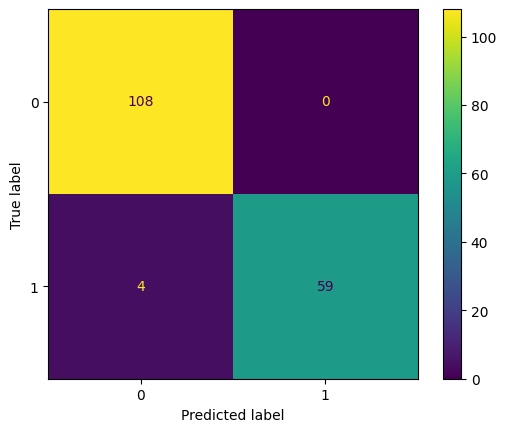

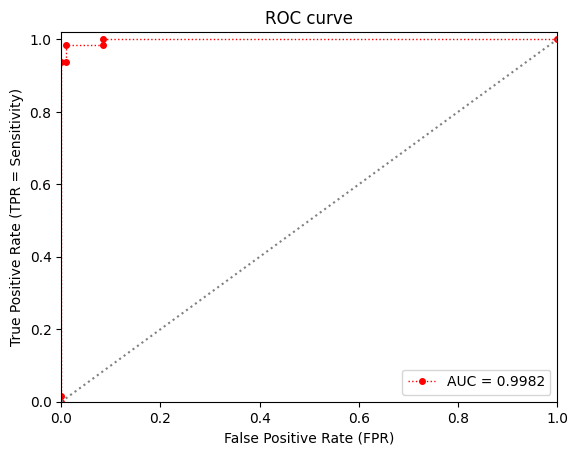

In [245]:
from sklearn.linear_model import LogisticRegression

df = import_dataset()
df = dataset_cleaning(df)
X, y = data_preprocessing(df, 
                          target_split=True, 
                          target_name='diagnosis', 
                          id_column=True, 
                          id_name='id', 
                          transform_categorical=True, 
                          scaling=True)

X_train, X_test, y_train, y_test = get_train_test_subsets(X, y)

model_trained = model_training(LogisticRegression(), X_train, y_train, id_column=True, id_name='id')
y_pred, y_prob = model_predictions(model_trained, X_test, id_column=True, id_name='id', prob=True)
metrics_, artifacts_ = model_evaluation(y_pred, y_prob, y_test)
experiment_id = mlflow_activation(model_trained)
mlflow_logging(exp_id=experiment_id,
              model=model_trained,
              metrics_=metrics_,
              artifacts_=artifacts_,
              X_train=X_train,
              id_column=True,
              id_name='id')

In [205]:
model_trained.__class__.__name__

'LogisticRegression'

In [206]:
f'{model_trained.__class__.__name__}WithMlflow'

'LogisticRegressionWithMlflow'